# Notebook for analysing simulation outputs

## Summary
* [1. Read & Process simulation outputs](#t1)
* [2. Compute water budget](#t2)
    * [2.1. Precipitation](#t2_1)
    * [2.2. Evapotranspiration](#t2_2)    
    * [2.3. Runoff](#t2_3)
    * [2.4. storage](#t2_4)    
    * [2.5. Compute and plot](#t2_5)
* [3. Compute energy budget](#t3)
* [4. Compute & plot ET](#t4)
* [5. Compute & plot runoff](#t5)
* [6. Compute & plot WT](#t6)
* [7. Compute & plot soil moisture](#t7)
* [8. Compute & plot water storage](#t8)
* [9. Compute & plot retention curves](#t9)




## 1. Read & Process simulation outputs <a class="anchor" id="t1"></a>

In [4]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
import datetime as dt

from parflow import read_pfb, read_pfb_sequence, ParflowBinaryReader
from parflow import Run

In [5]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/ara_bele/simus/"
wdir = root_dir+'results_benchmark/'
#wdir ='/home/hectorb/PARFLOW/PROJECTS/Hillslope/bele_nalo_tests/simus/docker_test/'
with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header

In [6]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get evaptranssum
    files = np.sort(glob.glob(wdir+'*.evaptranssum.*.pfb'))
    evaptranssum = read_pfb_sequence(files)
        
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "evaptranssum": (("time","z","y"), evaptranssum[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files)),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.evaptranssum.attrs['units']='m3/PFtimestep'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [7]:
#ds1 = read_and_process_pf_outputs(root_dir+'results_benchmark/')
ds1 = read_and_process_pf_outputs(wdir)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 24, 'dx': 10.0, 'dy': 10.0, 'dz': 1.0, 'n_subgrids': 2, 'p': 1, 'q': 2, 'r': 1}


In [1]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)

def read_clm_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)    
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec/2 
    
    files = np.sort(glob.glob(wdir+'*.clm_output.*.pfb'))
    clms = read_pfb_sequence(files)
    # create dataset
    ds = xr.Dataset({"lh_tot": (("time","y"), clms[:,0,:,0]),
                    "lwrad_out": (("time","y"), clms[:,1,:,0]),
                    "sh_tot": (("time","y"), clms[:,2,:,0]),
                    "soil_grnd": (("time","y"), clms[:,3,:,0]),
                    "evap_tot": (("time","y"), clms[:,4,:,0]*60*60),
                    "evap_grnd": (("time","y"), clms[:,5,:,0]*60*60),
                    "evap_soi": (("time","y"), clms[:,6,:,0]*60*60),
                    "evap_veg": (("time","y"), clms[:,7,:,0]*60*60),
                    "tran_veg": (("time","y"), clms[:,8,:,0]*60*60),
                    "infl": (("time","y"), clms[:,9,:,0]*60*60),
                    "swe_out": (("time","y"), clms[:,10,:,0]),
                    "t_grnd": (("time","y"), clms[:,11,:,0]),
                    "htop": (("time","y"), clms[:,12,:,0])},

        coords={
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
                    "z":-z,
            "time": pd.date_range(date_start, periods=len(files),freq='1H'),
            "reference_time": pd.Timestamp(date_start)})

    ds = ds.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
    ds = ds.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))

    ds.lh_tot.attrs['units']='$W/m^2$'
    ds.lwrad_out.attrs['units']='$W/m^2$'
    ds.sh_tot.attrs['units']='$W/m^2$'
    ds.soil_grnd.attrs['units']='$W/m^2$'
    ds.evap_tot.attrs['units']='mm/h'
    ds.evap_grnd.attrs['units']='mm/h'
    ds.evap_soi.attrs['units']='mm/h'
    ds.evap_veg.attrs['units']='mm/h'
    ds.tran_veg.attrs['units']='mm/h'
    ds.infl.attrs['units']='mm/h'
    ds.swe_out.attrs['units']='mm'
    ds.t_grnd.attrs['units']='K'
    ds.htop.attrs['units']='m'

    ds.y.attrs['units']='meters'
    return ds

In [6]:
#dc1 = read_clm_outputs(root_dir+'results_benchmark/')
dc1 = read_clm_outputs(wdir)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 24, 'dx': 10.0, 'dy': 10.0, 'dz': 1.0, 'n_subgrids': 2, 'p': 1, 'q': 2, 'r': 1}


In [10]:
dc1 = dc1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

In [11]:
hill = Run.from_definition(wdir+'hillslope.pfidb')

In [12]:
manning = hill.Mannings.Geom.domain.Value
dc1 = dc1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         10,10,manning)))
dc1.Q.attrs['units']='m3/CLMtimestep'


/tmp/ipykernel_14573/810169220.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


## 2. Compute water budget <a class="anchor" id="t2"></a>

### 2.1. Precipitation <a class="anchor" id="t2_1"></a>
Read forcing data

In [13]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(glob.glob(os.sep.join([wdir,'*forc*txt*']))[0],header=None,sep='\t')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2005 00:00:00', periods=len(forc), freq='30min')
P=forc['P']*30*60
forc

SWin   LWin    P       T  WindX  WindY    Press        Hs
2005-01-01 00:00:00  -3.0  331.3  0.0  291.75    1.0    0.0  96600.0  0.003954
2005-01-01 00:30:00  -3.0  328.8  0.0  290.75    0.6    0.0  96600.0  0.004013
2005-01-01 01:00:00  -2.8  326.5  0.0  290.25    0.6    0.0  96600.0  0.003976
2005-01-01 01:30:00  -2.0  326.0  0.0  289.95    0.8    0.0  96500.0  0.003880
2005-01-01 02:00:00  -2.6  325.4  0.0  289.65    0.9    0.0  96500.0  0.003818
...                   ...    ...  ...     ...    ...    ...      ...       ...
2015-12-31 21:30:00  -3.3  340.9  0.0  294.95    0.7    0.0  96510.0  0.004114
2015-12-31 22:00:00  -3.0  338.1  0.0  294.25    0.6    0.0  96510.0  0.004103
2015-12-31 22:30:00  -2.4  336.0  0.0  293.95    0.9    0.0  96510.0  0.004156
2015-12-31 23:00:00  -2.8  334.5  0.0  293.45    2.0    0.0  96500.0  0.004153
2015-12-31 23:30:00  -3.8  333.2  0.0  293.25    1.7    0.0  96500.0  0.004117

[192816 rows x 8 columns]

### 2.2. Evapotranspiration <a class="anchor" id="t2_2"></a>

Process evaptranssum file

In [14]:
tmp=xr.where(np.abs(ds1.z)<=np.abs(ds1.z[hill.Solver.CLM.RootZoneNZ-1]),ds1.evaptranssum*ds1.vdz,0).sum(dim="z").data
tmp=xr.where(ds1.z>=ds1.z[hill.Solver.CLM.RootZoneNZ-1],ds1.evaptranssum*ds1.vdz,0).sum(dim="z").data

tmp.shape

(730, 50)

In [15]:
ds1 = ds1.assign(ETsum=(("time","y"),tmp))
ETsum = ds1.ETsum.mean(dim=("y")).to_dataframe()['ETsum']

Convert to mm:

In [16]:
ETsum = ETsum*1000/h['dx']/h['dy'] #m3 -> mm

In [17]:
ETsum

time
2005-01-01   -0.145474
2005-01-02   -0.128110
2005-01-03   -0.119528
2005-01-04   -0.111943
2005-01-05   -0.131728
                ...   
2006-12-27   -0.958251
2006-12-28   -0.755270
2006-12-29   -0.690359
2006-12-30   -0.705622
2006-12-31   -0.599654
Freq: D, Name: ETsum, Length: 730, dtype: float64

P is included in evaptranssum (see manual)

In [18]:
ET = -(ETsum -P.resample('D').sum())

<AxesSubplot:>

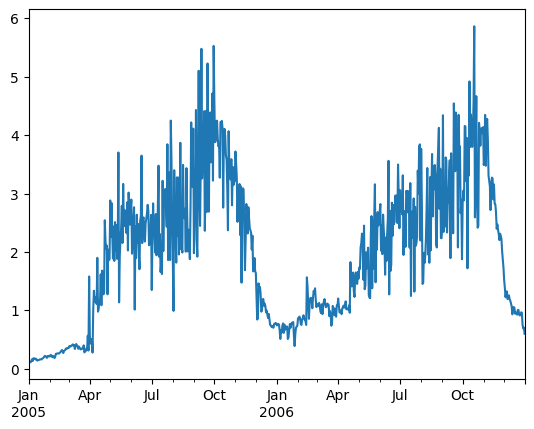

In [19]:
ET.dropna().plot()

### 2.3. Runoff <a class="anchor" id="t2_3"></a>

Convert to mm

In [20]:
Q = ds1.overlandsum.isel(y=0).to_dataframe()['overlandsum']*1000/h['dx']/h['dy']/h['ny']

In [21]:
Q = Q.rename('Q')

### 2.4. Storage <a class="anchor" id="t2_4"></a>

In [22]:
storage = ds1.storage.sum(dim='y').to_dataframe()['storage']*1000/h['dx']/h['dy']/h['ny']
storage = storage - storage[0]

In [23]:
storage

time
2005-01-01      0.000000
2005-01-02     -0.128110
2005-01-03     -0.247638
2005-01-04     -0.359581
2005-01-05     -0.491309
                 ...    
2006-12-27    641.282294
2006-12-28    640.527024
2006-12-29    639.836665
2006-12-30    639.131043
2006-12-31    638.531389
Freq: D, Name: storage, Length: 730, dtype: float64

### 2.5. Compute and plot <a class="anchor" id="t2_5"></a>


In [24]:
Budg = pd.DataFrame({'P':P.resample('Y').sum(),'ET':ET.resample('Y').sum(),'Q':Q.resample('Y').sum(),'WSC':np.nan})
for i, y in enumerate(np.sort(storage.index.year.unique())):
    if i ==0:
         Budg['WSC'][Budg.index.year==y] = storage[storage.index.year==y][-1]
    else:
         Budg['WSC'][Budg.index.year==y] = storage[storage.index.year==y][-1] - storage[storage.index.year==y-1][-1] 
Budg.index=Budg.index.year
Budg['closure'] = Budg['P']- Budg['ET']-Budg['Q']-Budg['WSC']
Budg

P          ET          Q         WSC       closure
2005  1213.8912  700.987347   0.000000  513.049326 -1.454733e-01
2006   913.0176  753.191092  34.344446  125.482062 -8.073810e-07
2007  1213.8912    0.000000        NaN         NaN           NaN
2008  1210.6476    0.000000        NaN         NaN           NaN
2009  1495.9260    0.000000        NaN         NaN           NaN
2010  1527.1380    0.000000        NaN         NaN           NaN
2011   934.3242    0.000000        NaN         NaN           NaN
2012  1422.4896    0.000000        NaN         NaN           NaN
2013   994.7970    0.000000        NaN         NaN           NaN
2014  1151.8704    0.000000        NaN         NaN           NaN
2015  1290.2922    0.000000        NaN         NaN           NaN

In [25]:
from matplotlib import pyplot as plt
def plot_clustered_stacked(dfall, labels=None,  H="/", axe=None, **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    fig = plt.figure(figsize=(10,4))
    if not axe:
        axe = fig.add_subplot(111)

    for df in dfall : # for each data frame
        if isinstance(df, pd.DataFrame):
            axe = df.plot(kind="bar",
            linewidth=0,
            stacked=True,
            ax=axe,
            legend=False,
            grid=False,
            **kwargs)  # make bar plots
        else:
             axe = df.plot(kind="bar",
             linewidth=0,
             stacked=True,
             ax=axe,
             legend=False,
             grid=False,
	     color='b',
             **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


In [26]:
Budg.dropna(inplace=True)

Text(0, 0.5, 'mm')

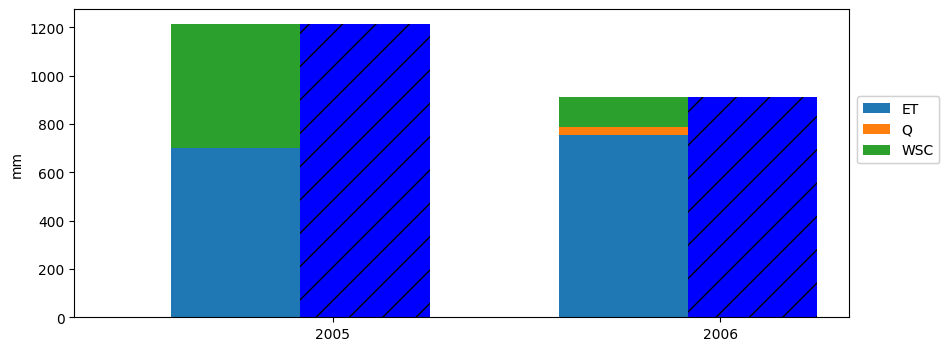

In [27]:
ax=plot_clustered_stacked([Budg.loc[:,['ET','Q','WSC']],Budg['P']])
ax.set_ylabel('mm')

## 3. Compute energy budget <a class="anchor" id="t3"></a>

In [28]:
dc1.lh_tot.mean(dim='y').resample(time='M').mean().to_dataframe().iloc[:,1]

time
2005-01-31      4.726309
2005-02-28      7.583253
2005-03-31     11.590390
2005-04-30     39.166720
2005-05-31     69.808944
2005-06-30     69.834649
2005-07-31     72.612532
2005-08-31     75.881010
2005-09-30    104.063953
2005-10-31    106.422337
2005-11-30     73.490873
2005-12-31     28.819673
2006-01-31     19.818756
2006-02-28     30.251100
2006-03-31     29.516788
2006-04-30     35.864872
2006-05-31     58.242646
2006-06-30     71.689317
2006-07-31     77.098558
2006-08-31     78.833325
2006-09-30     92.342294
2006-10-31    109.431659
2006-11-30     85.205526
2006-12-31     30.295096
Freq: M, Name: lh_tot, dtype: float64

In [29]:
dc1 = dc1.assign(Rn = lambda x: x.lh_tot+ x.sh_tot +x.soil_grnd)
dc1 = dc1.assign(swrad_out = lambda x: x.Rn - x.lwrad_out)

def resample_extract(x,method='M'): return x.mean(dim='y').resample(time=method).mean().to_dataframe().iloc[:,1]
method='M'
Ebudg = pd.DataFrame({'LE':resample_extract(dc1.lh_tot,method),
                     'H':resample_extract(dc1.sh_tot,method),
                     'G':resample_extract(dc1.soil_grnd,method),
                     'Rn':resample_extract(dc1.Rn,method),                      
                     'SWout':resample_extract(dc1.swrad_out,method),
                     'LWout':resample_extract(dc1.lwrad_out,method)})


Text(0, 0.5, '$W.m^{-2}$')

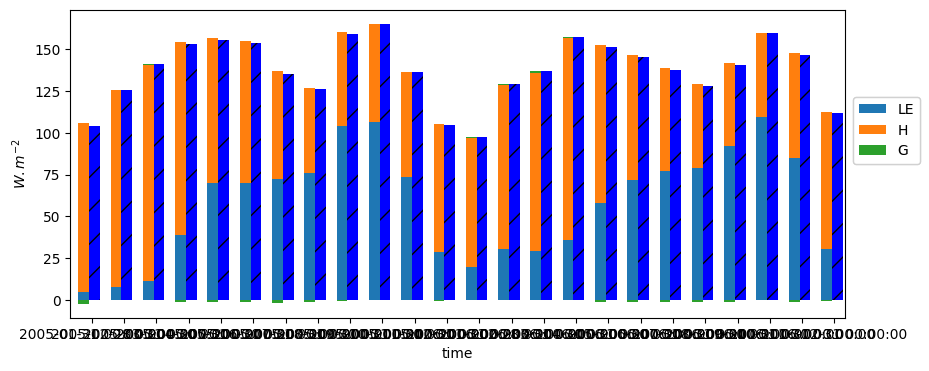

In [30]:
ax=plot_clustered_stacked([Ebudg.loc[:,['LE','H','G']],Ebudg['Rn']])
ax.set_ylabel('$W.m^{-2}$')

In [31]:
def resample_extract_downhill(x,method='M'): return x.isel(y=0).resample(time=method).mean().to_dataframe().iloc[:,-1]
def resample_extract_uphill(x,method='M'): return x.isel(y=-1).resample(time=method).mean().to_dataframe().iloc[:,-1]
method='M'
Ebudg_downhill = pd.DataFrame({'LE':resample_extract_downhill(dc1.lh_tot,method),
                     'H':resample_extract_downhill(dc1.sh_tot,method),
                     'G':resample_extract_downhill(dc1.soil_grnd,method),
                     'Rn':resample_extract_downhill(dc1.Rn,method),                      
                     'SWout':resample_extract_downhill(dc1.swrad_out,method),
                     'LWout':resample_extract_downhill(dc1.lwrad_out,method)})
Ebudg_uphill = pd.DataFrame({'LE':resample_extract_uphill(dc1.lh_tot,method),
                     'H':resample_extract_uphill(dc1.sh_tot,method),
                     'G':resample_extract_uphill(dc1.soil_grnd,method),
                     'Rn':resample_extract_uphill(dc1.Rn,method),                      
                     'SWout':resample_extract_uphill(dc1.swrad_out,method),
                     'LWout':resample_extract_uphill(dc1.lwrad_out,method)})


Text(0.5, 0, 'M')

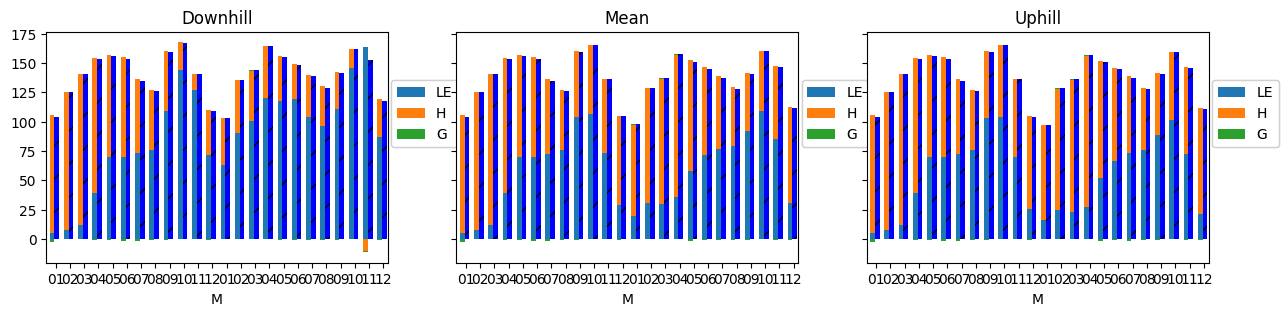

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [32]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,3))

#left: downhill
plot_clustered_stacked([Ebudg_downhill.loc[:,['LE','H','G']],Ebudg_downhill['Rn']],axe=ax[0])
ax[0].title.set_text('Downhill')
ax[0].set_xticklabels([item.get_text().split('-')[1] for item in ax[0].get_xticklabels()])
ax[0].set_xlabel(method)

#center: mean
plot_clustered_stacked([Ebudg.loc[:,['LE','H','G']],Ebudg['Rn']],axe=ax[1])
ax[1].title.set_text('Mean')
ax[1].set_xticklabels([item.get_text().split('-')[1] for item in ax[1].get_xticklabels()])
ax[1].set_xlabel(method)


#right: uphill
plot_clustered_stacked([Ebudg_uphill.loc[:,['LE','H','G']],Ebudg_uphill['Rn']],axe=ax[2])
ax[2].title.set_text('Uphill')
ax[2].set_xticklabels([item.get_text().split('-')[1] for item in ax[2].get_xticklabels()])
ax[2].set_xlabel(method)




In [33]:
def extract(x): return x.mean(dim='y').to_dataframe().iloc[:,1]
tmp = pd.concat([extract(dc1.Rn),extract(dc1.lh_tot),extract(dc1.sh_tot),
           extract(dc1.soil_grnd)],axis=1)
tmp2 = tmp.groupby(tmp.index.month).apply(lambda x: x.groupby(x.index.hour).mean())
tmp2.loc[1,:]
#tmp3 = tmp2.reset_index(0).rename(columns={'time':'month'})
#tmp4 = tmp3.melt(id_vars='month',value_vars=('Rn','lh_tot','sh_tot','soil_grnd'),value_name='flux',ignore_index=False)

Rn     lh_tot      sh_tot  soil_grnd
time                                              
0     -53.723484   0.828408  -22.278980 -32.272913
1     -53.606189   0.846983  -23.025108 -31.428064
2     -53.341243   0.781358  -23.272607 -30.849994
3     -53.252804   0.711019  -23.730087 -30.233737
4     -53.951276   0.457489  -24.631865 -29.776900
5     -53.790102   0.357497  -23.548023 -30.599576
6     -49.692658   0.682548  -20.859791 -29.515416
7      17.710412   5.962165   13.383370  -1.635123
8     174.230016  13.605699  124.159377  36.464940
9     336.511241  24.177953  243.274747  69.058541
10    459.749830  32.947566  340.762048  86.040217
11    526.319643  39.178516  397.827143  89.313984
12    532.205386  41.073223  411.407011  79.725151
13    469.781288  39.435478  371.981527  58.364283
14    377.778370  36.775576  306.433524  34.569270
15    235.767395  32.021655  195.490967   8.254773
16     65.172038  19.437715   55.271970  -9.537647
17    -70.756885   0.491802  -34.665644 -36.583042
18    -58.045347   0.592785  -16.525093 -42.113040
19    -55.595008   0.740743  -16.408750 -39.927001
20    -54.795555   0.834399  -18.587227 -37.042727
21    -56.133294   0.908313  -23.228280 -33.813326
22    -55.283178   0.866051  -23.229367 -32.919862
23    -53.889937   0.825838  -22.497805 -32.217970

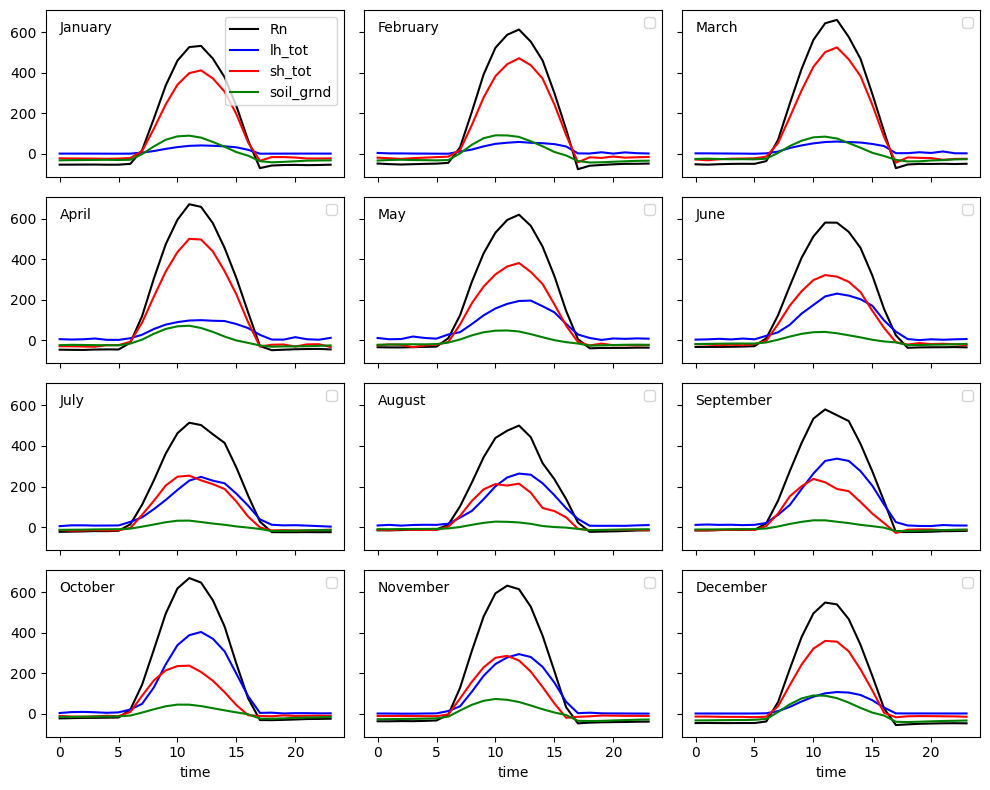

In [34]:
import calendar
fig, axes = plt.subplots(4,3,figsize=(10,8),squeeze=True,sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    tmp2.loc[i+1,:].plot(ax=ax,color=['k','b','r','g'])
    if i>0:ax.legend([])
    ax.text(0,600,calendar.month_name[i+1])
plt.tight_layout()

# 4. Compute & plot ET <a class="anchor" id="t4"></a>

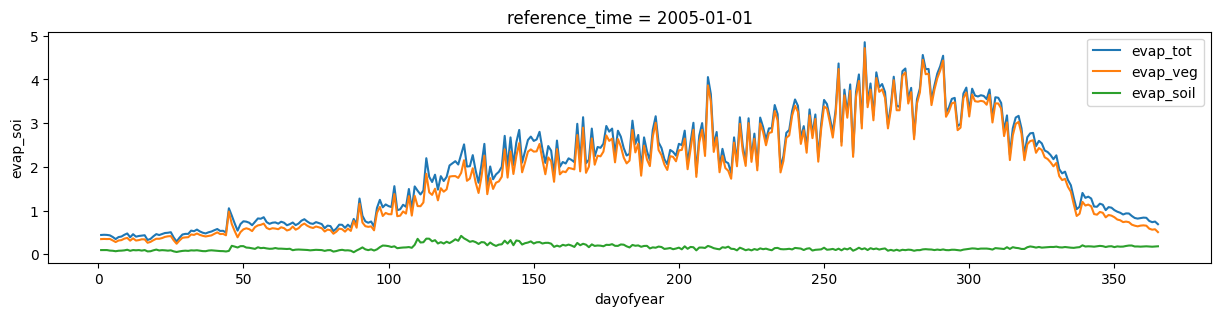

In [35]:
fig, ax = plt.subplots(figsize=(15,3))
dc1.evap_tot.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_tot')
dc1.evap_veg.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_veg')
dc1.evap_soi.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_soil')
a = plt.gca()
a.legend()

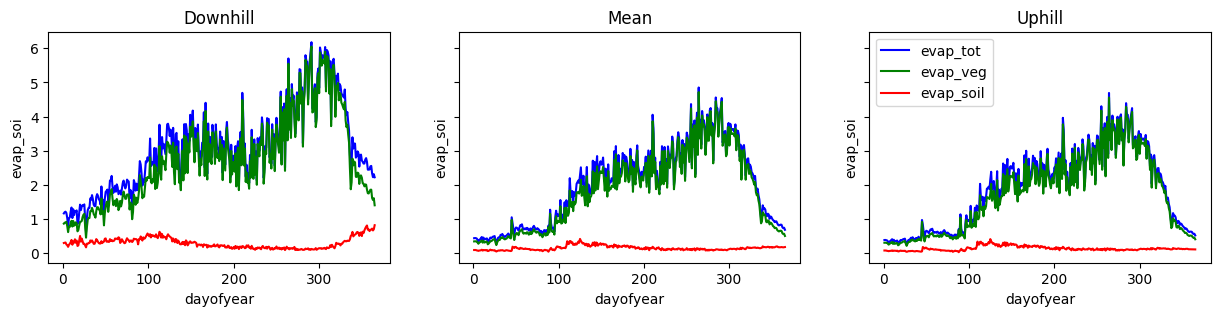

In [36]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,3))

#left: downhill
dc1.evap_tot.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0],label='evap_tot',color='b')
dc1.evap_veg.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0],label='evap_veg',color='g')
dc1.evap_soi.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0],label='evap_soil',color='r')
ax[0].title.set_text('Downhill')

#center: mean
dc1.evap_tot.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1],label='evap_tot',color='b')
dc1.evap_veg.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1],label='evap_veg',color='g')
dc1.evap_soi.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1],label='evap_soil',color='r')
ax[1].title.set_text('Mean')


#right: uphill
dc1.evap_tot.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[2],label='evap_tot',color='b')
dc1.evap_veg.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[2],label='evap_veg',color='g')
dc1.evap_soi.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[2],label='evap_soil',color='r')
ax[2].title.set_text('Uphill')

a = plt.gca()
a.legend()

In [37]:
T = dc1.evap_veg.resample(time='D').sum().mean(dim='time')

In [38]:
E = dc1.evap_soi.resample(time='D').sum().mean(dim='time')

In [39]:
T_E = dc1.evap_veg.resample(time='D').sum().mean(dim='time') / dc1.evap_soi.resample(time='D').sum().mean(dim='time')

In [40]:
WTD_hillslope=ds1.WTD.mean(dim='time')

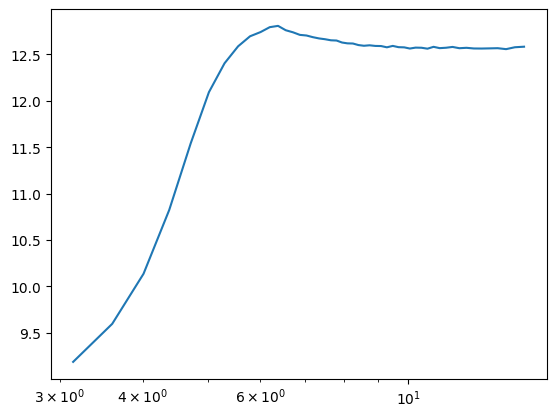

In [41]:
plt.semilogx(WTD_hillslope.data,T_E.data)

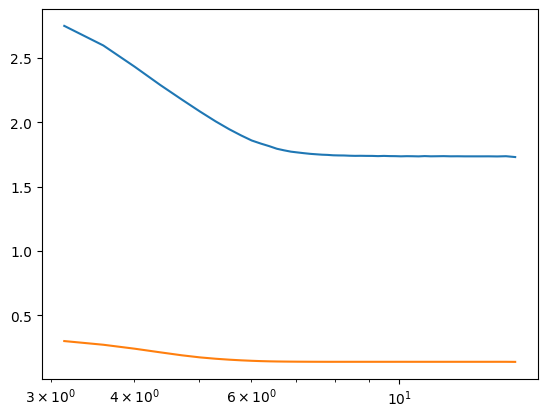

In [42]:
plt.semilogx(WTD_hillslope.data,T.data)
plt.semilogx(WTD_hillslope.data,E.data)

# 5. Compute & plot runoff <a class="anchor" id="t5"></a>

In [43]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [44]:
manning = hill.Mannings.Geom.domain.Value
dc1 = dc1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         10,10,manning)))
dc1.Q.attrs['units']='m3/CLMtimestep'


/tmp/ipykernel_14573/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


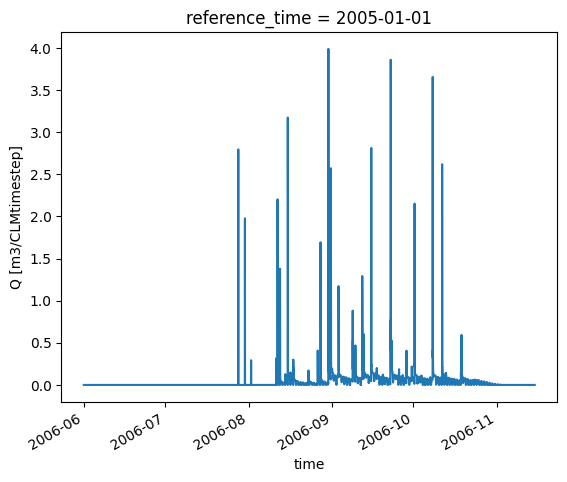

In [45]:
import datetime
dc1.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).plot()

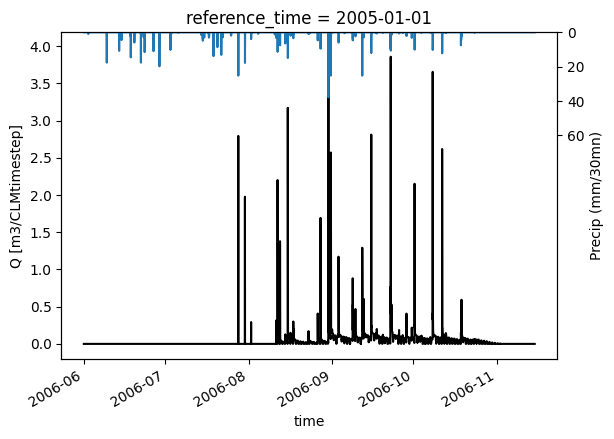

In [46]:
fig, ax = plt.subplots(1,1)
dc1.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).plot(ax=ax,color = 'k')
p1=ax.twinx() #declare second axis for precipitation
P.loc[(P.index>datetime.datetime(2006,6,1)) & (P.index<datetime.datetime(2006,11,15))].plot(ax=p1,x_compat=True)
p1.set_ylim([0,190])
p1.set_yticks([0,20,40,60])
p1.set_ylabel('Precip (mm/30mn)')
p1.invert_yaxis() # invert precipitation axis

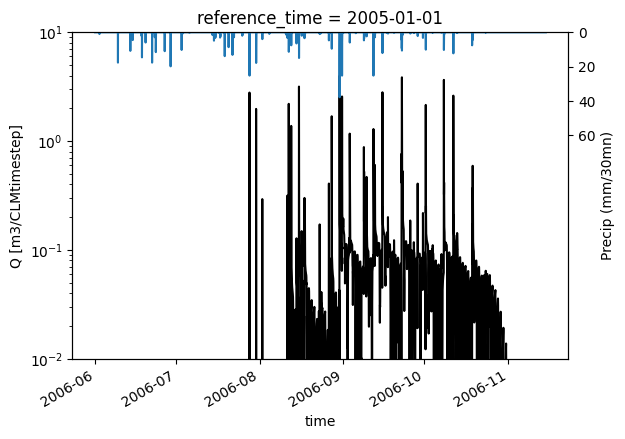

In [47]:
fig, ax = plt.subplots(1,1)
dc1.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).plot(yscale='log',ax=ax,color = 'k')
ax.set_ylim([0.01,10])
p1=ax.twinx() #declare second axis for precipitation
P.loc[(P.index>datetime.datetime(2006,6,1)) & (P.index<datetime.datetime(2006,11,15))].plot(ax=p1,x_compat=True)
p1.set_ylim([0,190])
p1.set_yticks([0,20,40,60])
p1.set_ylabel('Precip (mm/30mn)')
p1.invert_yaxis() # invert precipitation axis

# 6. Compute & plot WT <a class="anchor" id="t6"></a>

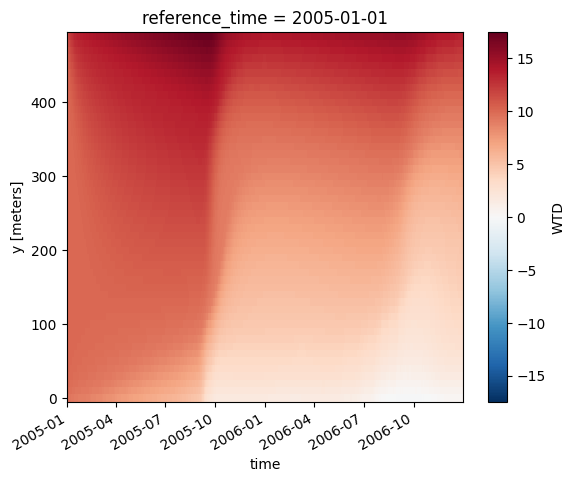

In [48]:
ds1.WTD.plot(x='time')

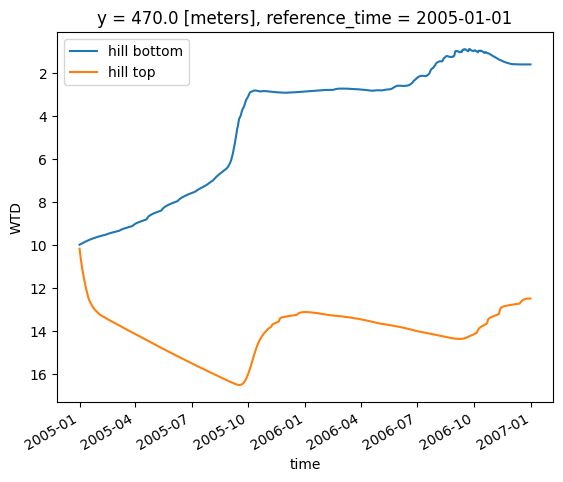

In [49]:
from matplotlib import pyplot as plt
ds1.WTD.isel(y=3).plot(label='hill bottom')
ds1.WTD.isel(y=47).plot(label='hill top')
plt.gca().legend()
plt.gca().invert_yaxis()

# 7. Compute & plot soil moisture <a class="anchor" id="t7"></a>

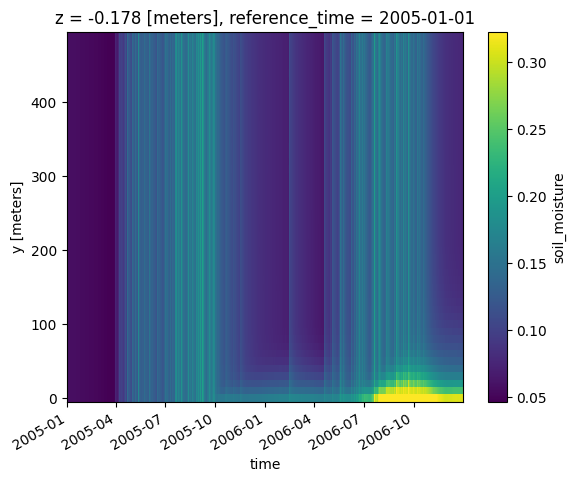

In [50]:
ds1.soil_moisture.isel(z=5).plot(x='time')

In [51]:
SM_uphill = ds1.soil_moisture.isel(y=-1).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)
SM_downhill = ds1.soil_moisture.isel(y=3).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)

In [52]:
#SM_uphill.plot(subplots=True, layout=(6,4),sharex=True,sharey=True)

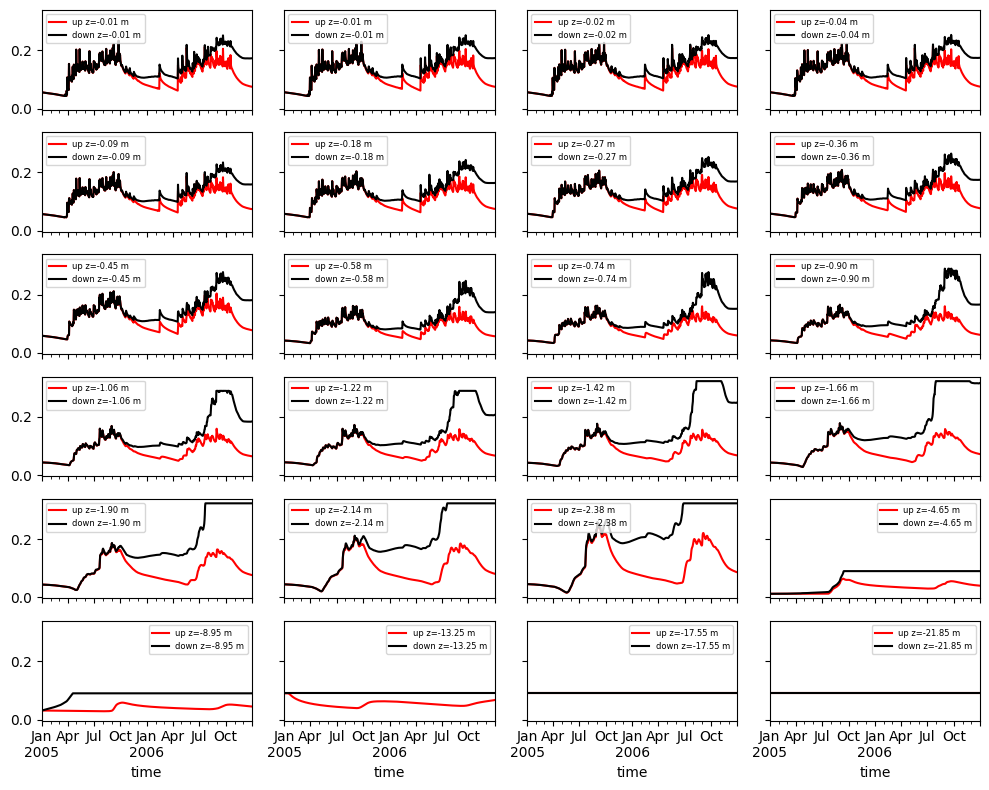

In [53]:
import calendar
fig, axes = plt.subplots(6,4,figsize=(10,8),squeeze=True,sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    SM_uphill.iloc[:,i].plot(ax=ax,color='r',label = 'up z=%2.2f m'%float(SM_uphill.columns[i]))
    SM_downhill.iloc[:,i].plot(ax=ax,color='k',label = 'down z=%2.2f m'%float(SM_downhill.columns[i]))
    ax.legend(fontsize=6)
plt.tight_layout()

# 8. Compute & plot water storage <a class="anchor" id="t8"></a>

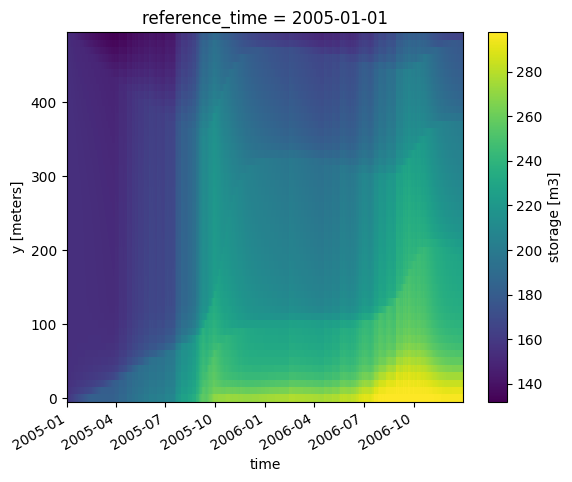

In [54]:
ds1.storage.plot(x='time')

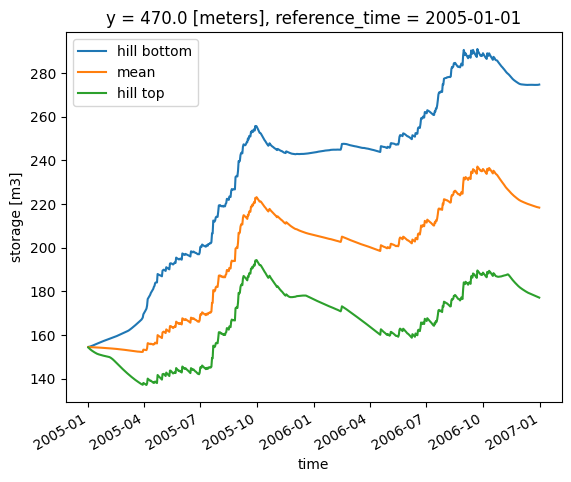

In [55]:
from matplotlib import pyplot as plt
ds1.storage.isel(y=3).plot(label='hill bottom')
ds1.storage.mean(dim='y').plot(label='mean')
ds1.storage.isel(y=47).plot(label='hill top')
plt.gca().legend()

# 9. Compute & plot retention curves <a class="anchor" id="t9"></a>

Some exemples to plot retention and conductivity curves... Modify at will to add other geometries

In [56]:
def calc_retention(h,thr,ths,hg,n):
    """
    """
    return thr+(ths-thr)*(1+(h/hg)**n)**(-(1-1/n))
    
    
def calc_cond(h,Ks,alpha,n):
    """
    """
    m=1-1/n
    return Ks*((1-((h*alpha)**(n-1))/((1+(h*alpha)**n)**m))**2)/((1+(h*alpha)**n)**(m/2))

Plot: 

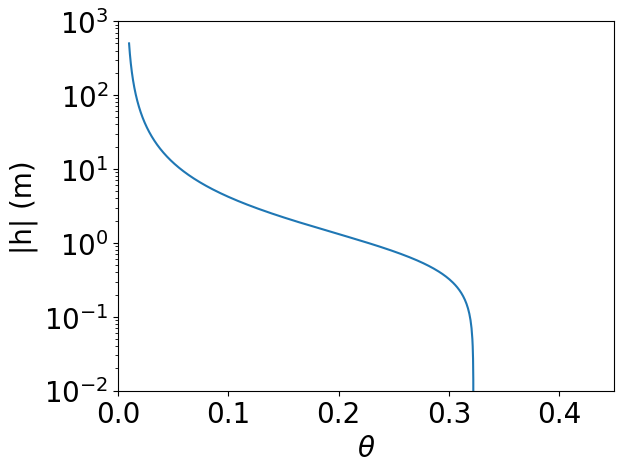

In [65]:
h=np.concatenate([np.arange(0.001,0.049,0.001),np.arange(0.05,1,0.01),np.arange(1.1,500,0.1)])        
th = calc_retention(h,thr = 
                    hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SRes.value(),
                    ths= hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SSat.value(),
                    hg= 1/hill.Geom.H1.Saturation.Alpha.value(),n = hill.Geom.H1.Saturation.N.value())

fig, ax = plt.subplots(1, 1)
ax.semilogy(th,h)
ax.set_xlim([0,0.45])
ax.set_ylim([0.01,1000])
#~ ax.legend((linesobs,linessim),['obs.','sim.'],loc='lower left',fontsize=28,ncol=1)
ax.set_ylabel('|h| (m)', fontsize=20, color = 'k')
ax.set_xlabel(r'$\theta$', fontsize=20, color = 'k')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()


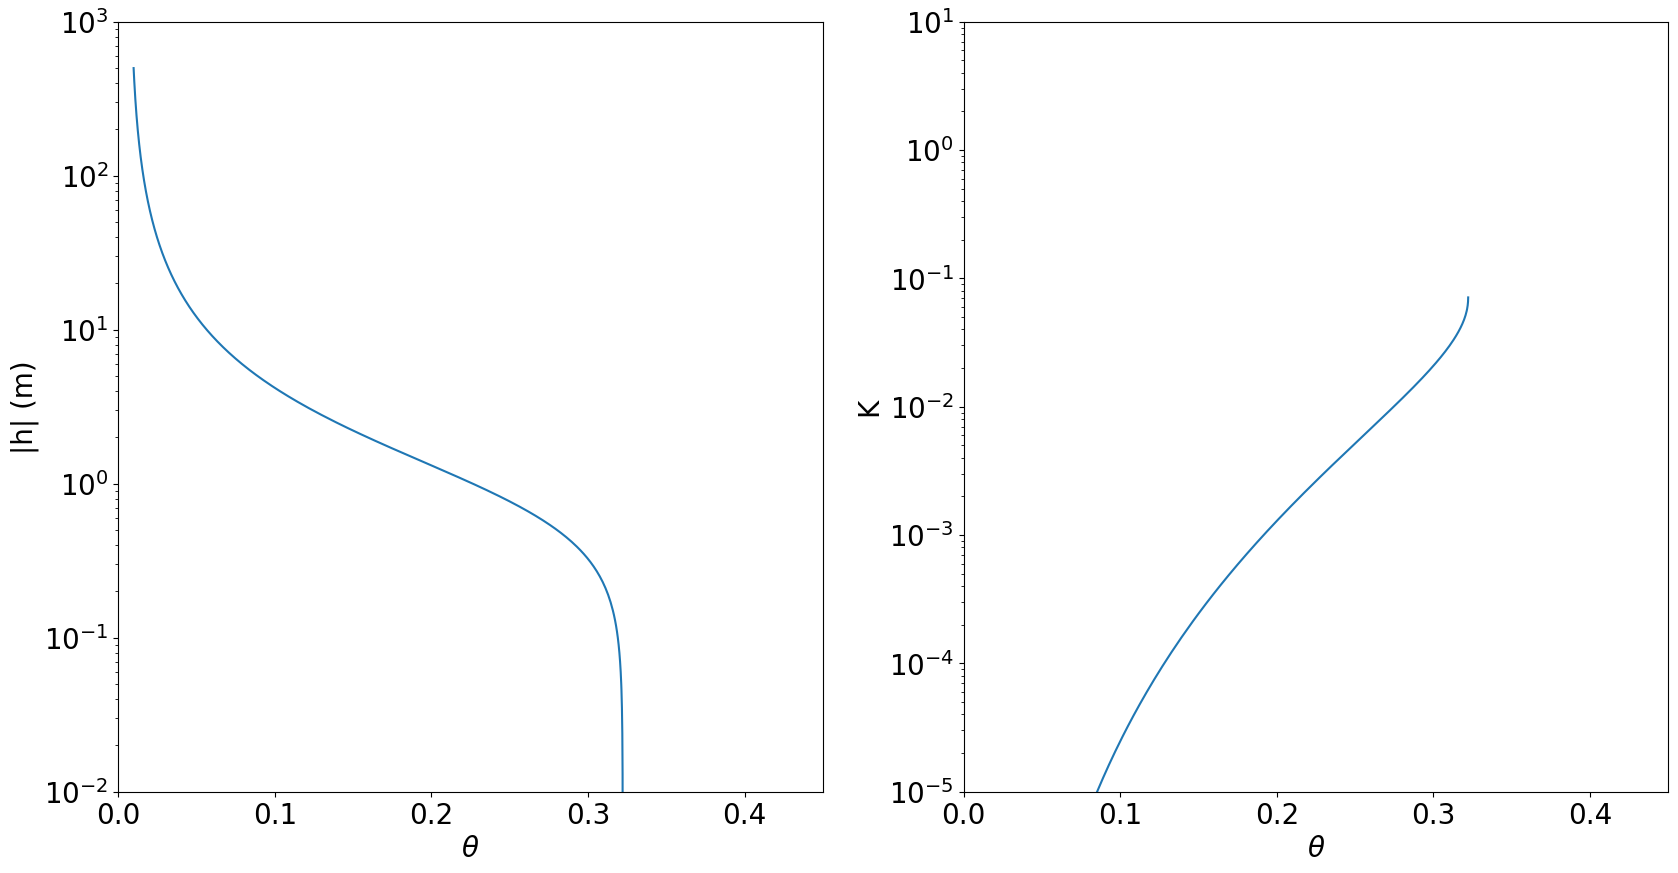

In [67]:
h=np.concatenate([np.arange(0.001,0.049,0.001),np.arange(0.05,1,0.01),np.arange(1.1,500,0.1)])        
th = calc_retention(h,thr = 
                    hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SRes.value(),
                    ths= hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SSat.value(),
                    hg= 1/hill.Geom.H1.Saturation.Alpha.value(),n = hill.Geom.H1.Saturation.N.value())

K = calc_cond(h,hill.Geom.H1.Perm.Value,
              alpha=hill.Geom.H1.Saturation.Alpha.value(),
              n = hill.Geom.H1.Saturation.N.value())
fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].semilogy(th,h)
ax[0].set_xlim([0,0.45])
ax[0].set_ylim([0.01,1000])
ax[0].set_ylabel('|h| (m)', fontsize=20, color = 'k')
ax[0].set_xlabel(r'$\theta$', fontsize=20, color = 'k')
ax[0].tick_params(axis='both', which='major', labelsize=20)

ax[1].semilogy(th,K)
ax[1].set_ylim([0.00001,10])
ax[1].set_xlim([0,0.45])
ax[1].set_ylabel('K', fontsize=20, color = 'k')
ax[1].set_xlabel(r'$\theta$', fontsize=20, color = 'k')
ax[1].tick_params(axis='both', which='major', labelsize=20)

plt.show()
